In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

sns.set(color_codes=True)
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [2]:
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv') 
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')   
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [3]:
print('No. of duplicated values at the the whole dataset is: ',train.duplicated().sum())
train['Transported'].value_counts()

No. of duplicated values at the the whole dataset is:  0


True     4378
False    4315
Name: Transported, dtype: int64

In [4]:
def info(dataset):
    
    for column in dataset.columns:
        print('==========%s =========='%column)
        print('Type is: ',dataset[column].dtype)
        print(dataset[column].value_counts())
        print('Number of unique values: ',dataset[column].nunique())
        print('Number of null values: ',dataset[column].isna().sum())

info(train)

==========PassengerId ==========
Type is:  object
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64
Number of unique values:  8693
Number of null values:  0
==========HomePlanet ==========
Type is:  object
Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64
Number of unique values:  3
Number of null values:  201
==========CryoSleep ==========
Type is:  object
False    5439
True     3037
Name: CryoSleep, dtype: int64
Number of unique values:  2
Number of null values:  217
==========Cabin ==========
Type is:  object
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64
Number of unique values:  6560
Number of null values:  199
==========Destination ==========
Type is:  object
TRAPPIST-1e   

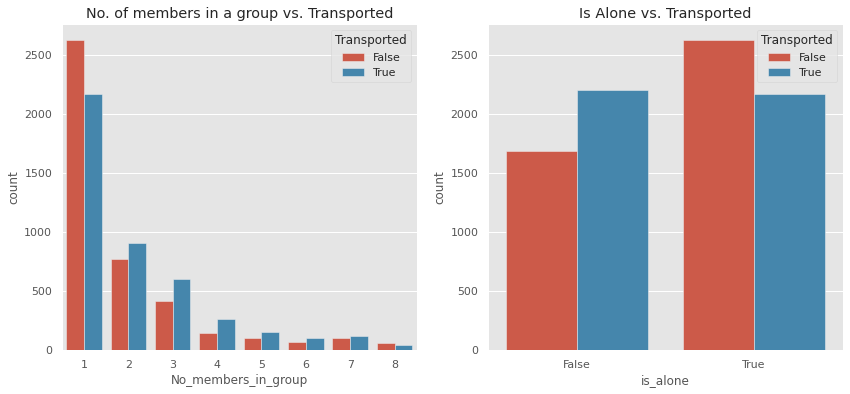

In [5]:
train[['Group','Member']]=train['PassengerId'].str.split('_',expand=True) # split PassengerId to Group, Member

x=train.groupby('Group')['Member'].count().sort_values(ascending=False) # Count members at each group

train['is_alone']=train['Group'].apply(lambda y: y not in set(x[x>1].index)) # create new column for groups have more than 1 member

train['No_members_in_group']=0   ## Creat new column for number of members in each group
for i in x.items():
    train.loc[train['Group']==i[0],'No_members_in_group']=i[1]
    
plt.figure(figsize=[14,6])

plt.subplot(1,2,1)
sns.countplot(data=train,x='No_members_in_group',hue='Transported')
plt.title('No. of members in a group vs. Transported')

plt.subplot(1,2,2)
sns.countplot(data=train,x='is_alone',hue='Transported') 
plt.title('Is Alone vs. Transported')

plt.show()

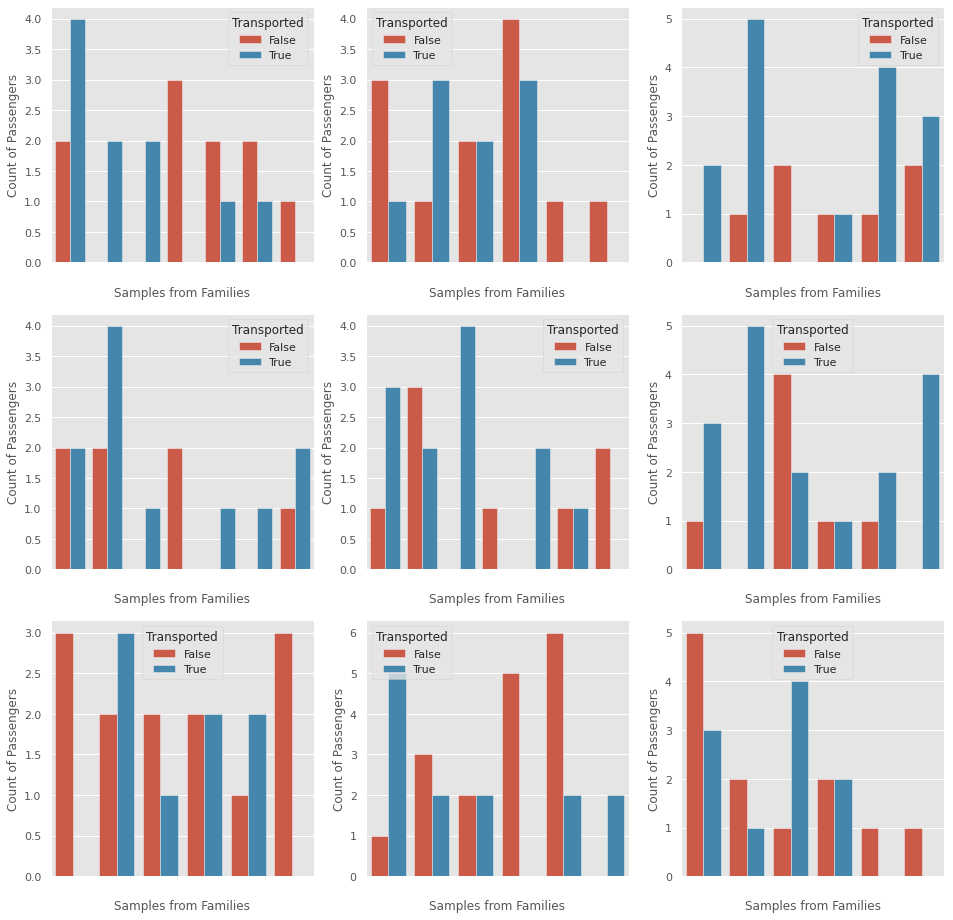

In [6]:
train['surname']=train['Name'].str.split(' ',expand=True)[1]
df_surname_grouped=train.groupby(['surname','Transported'])['PassengerId'].count()
df_surname_grouped=df_surname_grouped.reset_index()
df_surname_grouped.rename({'surname':'Family Name','PassengerId':'Count of Passengers'},axis=1,inplace=True)


plt.figure(figsize=[16,16])
j=1
for i in np.random.randint(0,df_surname_grouped.shape[0],9):
    plt.subplot(3,3,j)
    if df_surname_grouped.iloc[i,1]== False:
        sns.barplot(data=df_surname_grouped[i:i+10],x='Family Name',y='Count of Passengers',hue='Transported')
        plt.xlabel('Samples from Families')
        plt.xticks(color='w')
    else:
        sns.barplot(data=df_surname_grouped[i+1:i+11],x='Family Name',y='Count of Passengers',hue='Transported')
        plt.xlabel('Samples from Families')
        plt.xticks(color='w')
    
    j+=1

plt.show()


 Analyzing the graphs here, it turns out that the values of the variables are not normally distributed. 



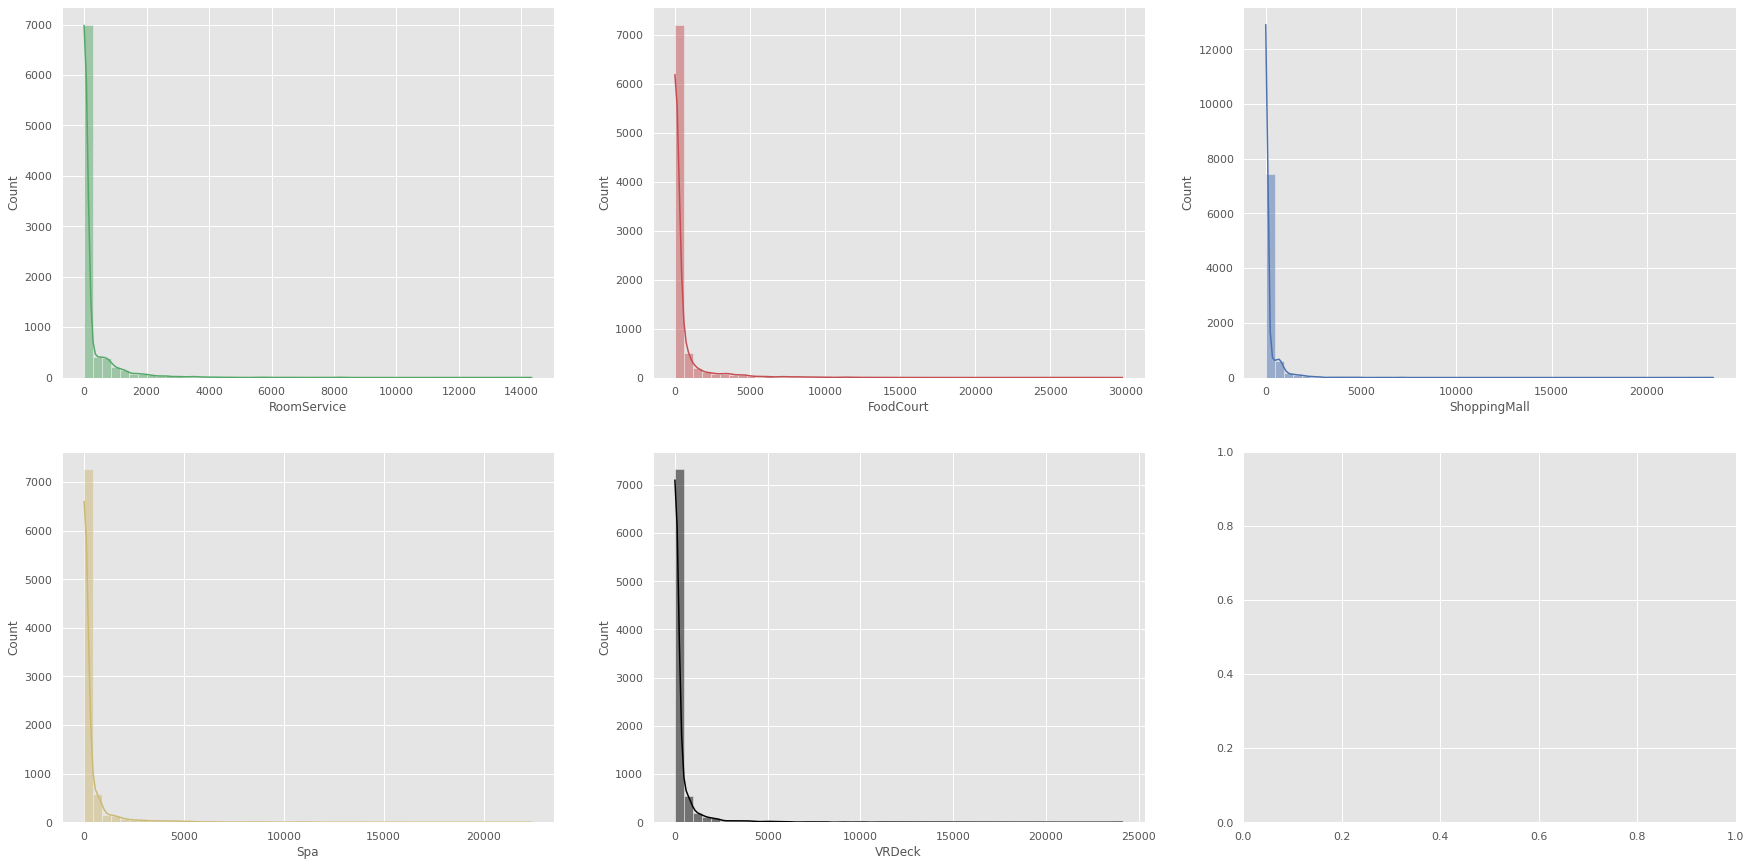

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(30, 15))
axes = axes.flatten()
amenities=["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
colors=['g','r','b','y','black']
no=[0,1,2,3,4,5]

for n, i, j in zip(no,amenities,colors):
    sns.histplot(ax = axes[n],x=train[i],kde=True,bins=50,color=j)
    
print("\n Analyzing the graphs here, it turns out that the values of the variables are not normally distributed. \n")

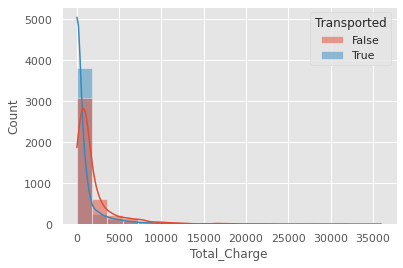

In [8]:
train['Total_Charge']=train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
sns.histplot(x=train['Total_Charge'],kde=True,bins=20,hue=train['Transported'])
plt.show()

"
 Analyzing the graphs here, it turns out that the Most transported passengers were not payed for Titanic's Luxury Anemities
"


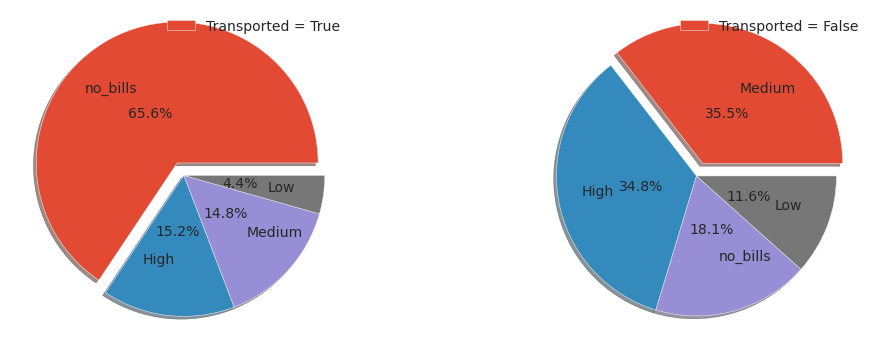

In [9]:
train['Total_Amenities_Billed_Category']='no_bills'

train.loc[(train['Total_Charge']>0) & 
            (train['Total_Charge']<=716),'Total_Amenities_Billed_Category']='Low'

train.loc[(train['Total_Charge']>716) & 
            (train['Total_Charge']<=1442),'Total_Amenities_Billed_Category']='Medium'

train.loc[train['Total_Charge']>1442,'Total_Amenities_Billed_Category']='High'

amenities_transported_df=train.loc[train['Transported']==True,'Total_Amenities_Billed_Category'].value_counts()
amenities_not_transported_df=train.loc[train['Transported']==False,'Total_Amenities_Billed_Category'].value_counts()

plt.figure(figsize=[8,6])
plt.subplot(1,2,1)
plt.pie(amenities_transported_df,labels=amenities_transported_df.index,
       explode=[0.1,0,0,0],autopct='%1.1f%%',shadow=True,textprops={'size':14},
       labeldistance=0.6,pctdistance=0.4)
plt.legend(['Transported = True'],loc='upper right',fontsize=14,frameon=False)
plt.axis('equal')

plt.subplot(1,2,2)
plt.pie(amenities_not_transported_df,labels=amenities_not_transported_df.index,
       explode=[0.1,0,0,0],autopct='%1.1f%%',shadow=True,textprops={'size':14},
       labeldistance=0.6,pctdistance=0.4)

plt.axis('equal')
plt.legend(['Transported = False'],loc='upper right',fontsize=14,frameon=False)
plt.subplots_adjust(left=0,right=1.5,wspace=0.5)
print('"\n Analyzing the graphs here, it turns out that the Most transported passengers were not payed for \
Titanic\'s Luxury Anemities\n"')
plt.show()

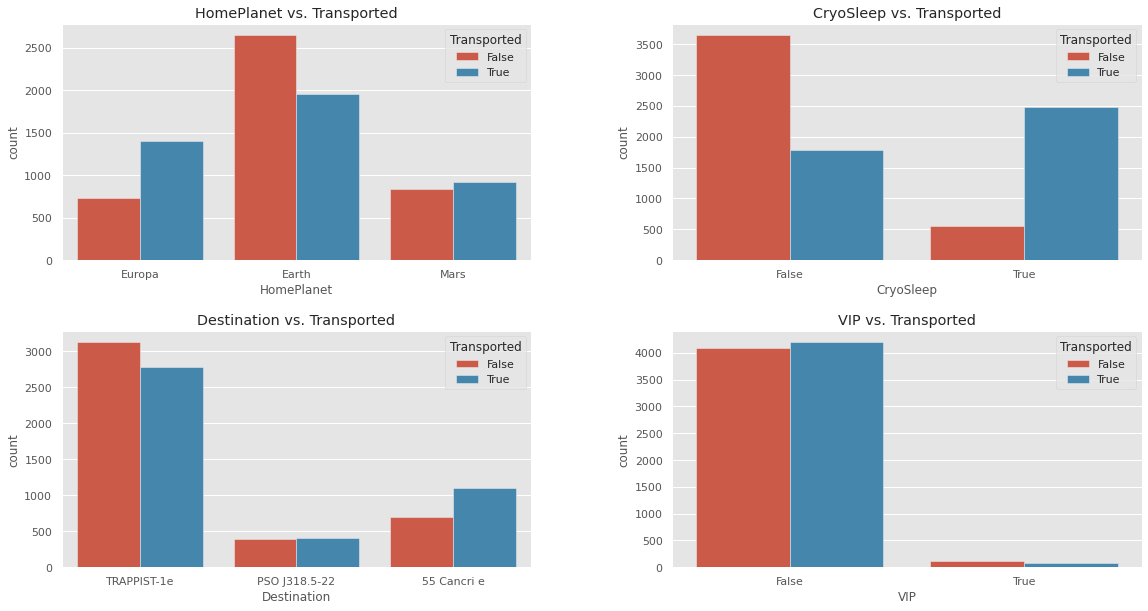

In [10]:
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
sns.countplot(data=train,x='HomePlanet',hue='Transported')
plt.title('HomePlanet vs. Transported')

plt.subplot(2,2,2)
sns.countplot(data=train,x='CryoSleep',hue='Transported')
plt.title('CryoSleep vs. Transported')

plt.subplot(2,2,3)
sns.countplot(data=train,x='Destination',hue='Transported')
plt.title('Destination vs. Transported')

plt.subplot(2,2,4)
sns.countplot(data=train,x='VIP',hue='Transported')
plt.title('VIP vs. Transported')

plt.subplots_adjust(left=0,right=1.5,wspace=0.3,hspace=0.3)
plt.show()

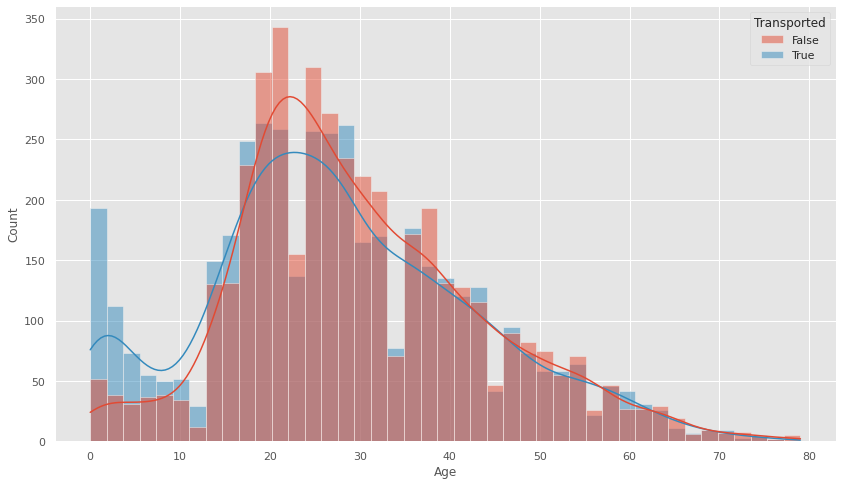

In [11]:
plt.figure(figsize=[14,8])
sns.histplot(data=train,x='Age',hue='Transported',kde=True)
plt.show()

In [12]:
train[["Cabin_deck","Cabin_no.","Cabin_side"]]=train["Cabin"].str.split("/",expand=True)
train[["Cabin_deck","Cabin_no.","Cabin_side"]].nunique()

Cabin_deck       8
Cabin_no.     1817
Cabin_side       2
dtype: int64

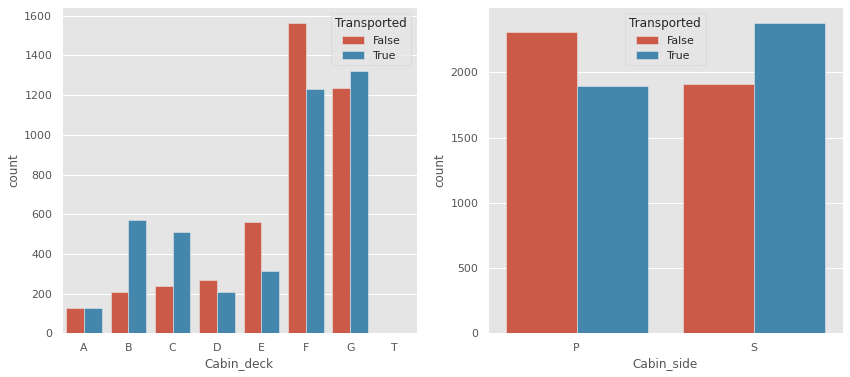

In [13]:
plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
sns.countplot(data=train,x='Cabin_deck',hue='Transported',order=['A','B','C','D','E','F','G','T'])
plt.subplot(1,2,2)
sns.countplot(data=train,x='Cabin_side',hue='Transported')
plt.show()

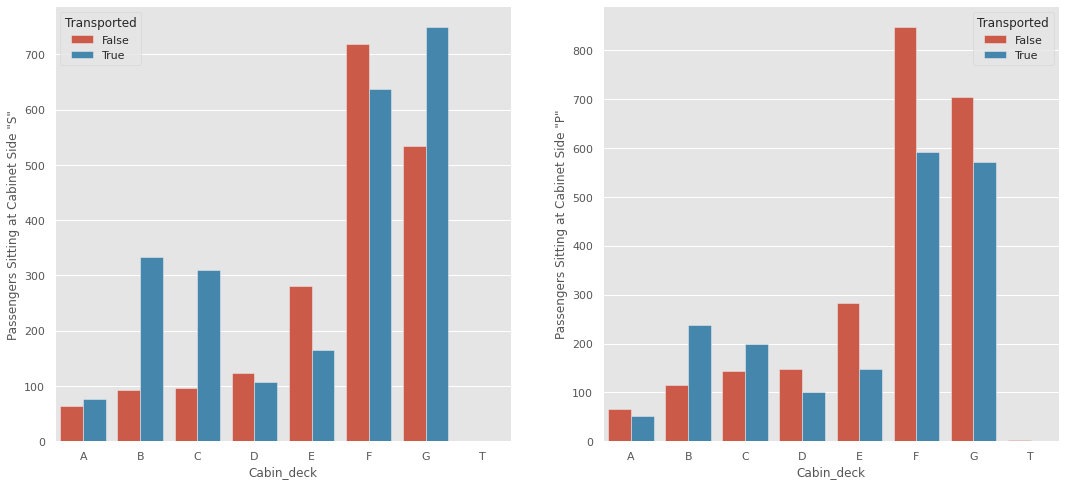

In [14]:
cabin_s=train[train['Cabin_side']=='S'].groupby(['Cabin_deck','Transported'])['Cabin_side'].count().reset_index()
cabin_p=train[train['Cabin_side']=='P'].groupby(['Cabin_deck','Transported'])['Cabin_side'].count().reset_index()
plt.figure(figsize=[18,8])
plt.subplot(1,2,1)
sns.barplot(data=cabin_s,x='Cabin_deck',y='Cabin_side',hue='Transported')
plt.ylabel('Passengers Sitting at Cabinet Side "S"')
plt.subplot(1,2,2)
sns.barplot(data=cabin_p,x='Cabin_deck',y='Cabin_side',hue='Transported')
plt.ylabel('Passengers Sitting at Cabinet Side "P"')
plt.show()

In [15]:
categorical_cols=['HomePlanet', 'CryoSleep','Destination', 'Age','VIP', 'RoomService', 'FoodCourt', 
      'ShoppingMall', 'Spa', 'VRDeck','Transported','is_alone','No_members_in_group', 'Total_Charge',
      'Cabin_deck','Cabin_side']

numerical_cols=['Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Transported',
                'is_alone','No_members_in_group', 'Total_Charge']

print("=====================Most of Transported Passengers Statistics=====================\n")
print('Categorical Columns\n')
print(train.loc[train['Transported']==True,categorical_cols].describe(include='object'))
print('\nNumerical Columns\n')
print(train.loc[train['Transported']==True,numerical_cols].describe())
print("\n=====================Most of Not Transported Passengers Statistics=====================\n")
print('Categorical Columns\n')
print(train.loc[train['Transported']==False,categorical_cols].describe(include='object'))
print('\nNumerical Columns\n')
print(train.loc[train['Transported']==False,numerical_cols].describe())
print("\n=============================== End of EDA =====================================\n")

=====================Most of Transported Passengers Statistics=====================

Categorical Columns

       HomePlanet CryoSleep  Destination    VIP Cabin_deck Cabin_side
count        4275      4272         4286   4274       4278       4278
unique          3         2            3      2          8          2
top         Earth      True  TRAPPIST-1e  False          G          S
freq         1951      2483         2787   4198       1321       2380

Numerical Columns

               Age  RoomService     FoodCourt  ShoppingMall          Spa  \
count  4288.000000  4295.000000   4279.000000   4264.000000  4287.000000   
mean     27.748834    63.098021    532.691984    179.829972    61.675531   
std      15.151705   274.812497   1931.306995    722.026714   262.682871   
min       0.000000     0.000000      0.000000      0.000000     0.000000   
25%      18.000000     0.000000      0.000000      0.000000     0.000000   
50%      26.000000     0.000000      0.000000      0.000000     0.00

In [16]:
test[['Group','Member']]=test['PassengerId'].str.split('_',expand=True)
x=test.groupby('Group')['Member'].count().sort_values(ascending=False)
test['is_alone']=test['Group'].apply(lambda y: y not in set(x[x>1].index)) 
test['No_members_in_group']=0   
for i in x.items():
    test.loc[test['Group']==i[0],'No_members_in_group']=i[1]
    
test['surname']=test['Name'].str.split(' ',expand=True)[1]

test['Total_Charge']=test[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

test['Total_Amenities_Billed_Category']='no_bills'
test.loc[(test['Total_Charge']>0) & (test['Total_Charge']<=716),'Total_Amenities_Billed_Category']='Low'
test.loc[(test['Total_Charge']>716) & (test['Total_Charge']<=1442),'Total_Amenities_Billed_Category']='Medium'
test.loc[test['Total_Charge']>1442,'Total_Amenities_Billed_Category']='High'

test[["Cabin_deck","Cabin_no.","Cabin_side"]]=test["Cabin"].str.split("/",expand=True)

In [17]:
target=train['Transported']  ## Will be used then for model fitting. 
train_rows=train.shape[0]  

combine=pd.concat([train,test],sort=False, ignore_index=True)  ## Combine Taining / Testing Datasets

cols_to_drop=['PassengerId', 'Cabin', 'Name','Transported',  'Group', 'Member', 'No_members_in_group',
             'Total_Amenities_Billed_Category', 'is_alone']

combine=combine.drop(cols_to_drop, axis=1)

In [18]:
count_missing_values=combine.isna().sum()
percentage=np.round((count_missing_values/combine.shape[0])*100,2)
missing_val_df=pd.DataFrame({'count_missing_values':count_missing_values,'percentage %':percentage})
missing_val_df

,count_missing_values,percentage %
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


In [19]:
categoriacl_cols=['HomePlanet', 'CryoSleep', 'Destination','VIP', 'surname',
                  'Cabin_deck', 'Cabin_no.','Cabin_side']

numerical_cols=['Age','RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Total_Charge']

def fill_missing(df):
    
    for ft in categoriacl_cols:
        df[ft].fillna(df[ft].mode()[0],inplace=True)
        
    for ft in numerical_cols:
        df[ft].fillna(df[ft].median(),inplace=True)
        
    return df

fill_missing(combine)
combine.isna().any()

HomePlanet      False
CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
surname         False
Total_Charge    False
Cabin_deck      False
Cabin_no.       False
Cabin_side      False
dtype: bool

In [20]:
def encoder(df):
    
    for ft in categoriacl_cols:
        le=LabelEncoder()
        le.fit(df[ft])
        df[ft]=le.transform(df[ft])
        
    for ft in numerical_cols:
        df[ft]=np.log1p(df[ft])
    
    return df

combine=encoder(combine)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  int64  
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  int64  
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  surname       12970 non-null  int64  
 11  Total_Charge  12970 non-null  float64
 12  Cabin_deck    12970 non-null  int64  
 13  Cabin_no.     12970 non-null  int64  
 14  Cabin_side    12970 non-null  int64  
dtypes: float64(7), int64(8)
memory usage: 1.5 MB


In [21]:
train=combine.iloc[:train_rows,:]
test=combine.iloc[train_rows:,:]

X=train.values

let=LabelEncoder()
let.fit(target)
y=let.transform(target)

print('X shape is: ',X.shape)
print('y shape is: ',y.shape)

X shape is:  (8693, 15)
y shape is:  (8693,)
